In [1]:
import os, subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist

from plotter import *

In [2]:
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

with open('xsec.json') as f:
  xs = json.load(f)

with open('pmap.json') as f:
  pmap = json.load(f)

systematics = ['nominal',
               'jet_triggerUp','jet_triggerDown',
               'btagWeightUp','btagWeightDown','btagEffStatUp','btagEffStatDown',
               'UESUp','UESDown','JESUp','JESDown','JERUp','JERDown',
              ]

In [3]:
year = '2016'
nfiles = len(subprocess.getoutput("ls infiles-split/"+year+"*.json").split())
outsum = processor.dict_accumulator()

In [4]:
# Load all files
for n in range(1,nfiles+1):

    with open('infiles-split/'+year+'_'+str(n)+'.json') as f:
      infiles = json.load(f)
    
    filename = '/myeosdir/vbf-category/outfiles/'+year+'_'+str(n)+'.coffea'
    if os.path.isfile(filename):
        out = util.load(filename)
        outsum.add(out)
    else:
        print(n,infiles.keys())
        #print("File " + filename + " is missing")
        
scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}
outsum['templates'].scale(scale_lumi, 'dataset')
outsum['templates-vbf'].scale(scale_lumi, 'dataset')
outsum['muonkin'].scale(scale_lumi, 'dataset')
outsum['mujetkin'].scale(scale_lumi, 'dataset')
outsum['cutflow_msd'].scale(scale_lumi, 'dataset')

1 dict_keys(['DYJetsToLL_M-50_HT-1200to2500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8'])
3 dict_keys(['DYJetsToLL_M-50_HT-2500toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8'])
5 dict_keys(['DYJetsToLL_M-50_HT-400to600_TuneCUETP8M1_13TeV-madgraphMLM-pythia8'])
6 dict_keys(['DYJetsToLL_M-50_HT-400to600_TuneCUETP8M1_13TeV-madgraphMLM-pythia8'])
7 dict_keys(['DYJetsToLL_M-50_HT-400to600_TuneCUETP8M1_13TeV-madgraphMLM-pythia8'])
8 dict_keys(['DYJetsToLL_M-50_HT-400to600_TuneCUETP8M1_13TeV-madgraphMLM-pythia8'])
9 dict_keys(['DYJetsToLL_M-50_HT-400to600_TuneCUETP8M1_13TeV-madgraphMLM-pythia8'])
10 dict_keys(['DYJetsToLL_M-50_HT-400to600_TuneCUETP8M1_13TeV-madgraphMLM-pythia8'])
11 dict_keys(['DYJetsToLL_M-50_HT-400to600_TuneCUETP8M1_13TeV-madgraphMLM-pythia8'])
13 dict_keys(['DYJetsToLL_M-50_HT-600to800_TuneCUETP8M1_13TeV-madgraphMLM-pythia8'])
14 dict_keys(['DYJetsToLL_M-50_HT-600to800_TuneCUETP8M1_13TeV-madgraphMLM-pythia8'])
15 dict_keys(['DYJetsToLL_M-50_HT-600to800_TuneCUETP8M1_13TeV-madgrap

364 dict_keys(['ST_tW_antitop_5f_inclusiveDecays_TuneCP5_PSweights_13TeV-powheg-pythia8'])
365 dict_keys(['ST_tW_antitop_5f_inclusiveDecays_TuneCP5_PSweights_13TeV-powheg-pythia8'])
366 dict_keys(['ST_tW_antitop_5f_inclusiveDecays_TuneCP5_PSweights_13TeV-powheg-pythia8'])
368 dict_keys(['ST_tW_top_5f_inclusiveDecays_TuneCP5_PSweights_13TeV-powheg-pythia8'])
369 dict_keys(['ST_tW_top_5f_inclusiveDecays_TuneCP5_PSweights_13TeV-powheg-pythia8'])
370 dict_keys(['ST_tW_top_5f_inclusiveDecays_TuneCP5_PSweights_13TeV-powheg-pythia8'])
580 dict_keys(['TTTo2L2Nu_TuneCP5_PSweights_13TeV-powheg-pythia8'])
581 dict_keys(['TTTo2L2Nu_TuneCP5_PSweights_13TeV-powheg-pythia8'])
582 dict_keys(['TTTo2L2Nu_TuneCP5_PSweights_13TeV-powheg-pythia8'])
583 dict_keys(['TTTo2L2Nu_TuneCP5_PSweights_13TeV-powheg-pythia8'])
584 dict_keys(['TTTo2L2Nu_TuneCP5_PSweights_13TeV-powheg-pythia8'])
585 dict_keys(['TTTo2L2Nu_TuneCP5_PSweights_13TeV-powheg-pythia8'])
586 dict_keys(['TTTo2L2Nu_TuneCP5_PSweights_13TeV-powheg-p

719 dict_keys(['VBFHToBB_M-125_13TeV_powheg_pythia8_weightfix'])
721 dict_keys(['WJetsToLNu_HT-1200To2500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8'])
722 dict_keys(['WJetsToLNu_HT-1200To2500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8'])
723 dict_keys(['WJetsToLNu_HT-1200To2500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8'])
724 dict_keys(['WJetsToLNu_HT-1200To2500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8'])
725 dict_keys(['WJetsToLNu_HT-1200To2500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8'])
727 dict_keys(['WJetsToLNu_HT-200To400_TuneCUETP8M1_13TeV-madgraphMLM-pythia8'])
728 dict_keys(['WJetsToLNu_HT-200To400_TuneCUETP8M1_13TeV-madgraphMLM-pythia8'])
729 dict_keys(['WJetsToLNu_HT-200To400_TuneCUETP8M1_13TeV-madgraphMLM-pythia8'])
730 dict_keys(['WJetsToLNu_HT-200To400_TuneCUETP8M1_13TeV-madgraphMLM-pythia8'])
731 dict_keys(['WJetsToLNu_HT-200To400_TuneCUETP8M1_13TeV-madgraphMLM-pythia8'])
732 dict_keys(['WJetsToLNu_HT-200To400_TuneCUETP8M1_13TeV-madgraphMLM-pythia8'])
733 dict_keys(['WJetsToLNu_HT-200T

In [5]:
cutflow = outsum['cutflow_msd'].group('dataset', hist.Cat('process', 'Process'), pmap).sum('genflavor').integrate('region','muoncontrol').sum('msd')

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f292b407220>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


In [6]:
cutflow.integrate('process','muondata').values()

{(): array([1.1224182e+07, 3.7190510e+06, 5.0838100e+05, 5.0838100e+05,
        1.7619100e+05, 5.6893000e+04, 5.3023000e+04, 7.3450000e+03,
        3.8490000e+03, 0.0000000e+00, 0.0000000e+00])}

In [7]:
cutflow.integrate('process','ttbar').values()

{(): array([3.42092159e+05, 3.42092159e+05, 1.84190757e+05, 1.84190757e+05,
        6.72826096e+04, 3.30193070e+04, 3.10905075e+04, 3.39664074e+01,
        3.39664074e+01, 0.00000000e+00, 0.00000000e+00])}

In [8]:
templates = outsum['templates'].group('dataset', hist.Cat('process', 'Process'), pmap).integrate('systematic','nominal')
muonkin = outsum['muonkin'].group('dataset', hist.Cat('process', 'Process'), pmap).integrate('systematic','nominal')
mujetkin = outsum['mujetkin'].group('dataset', hist.Cat('process', 'Process'), pmap).integrate('systematic','nominal')

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f292b3a31f0>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f292b3af460>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f292b3af970>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


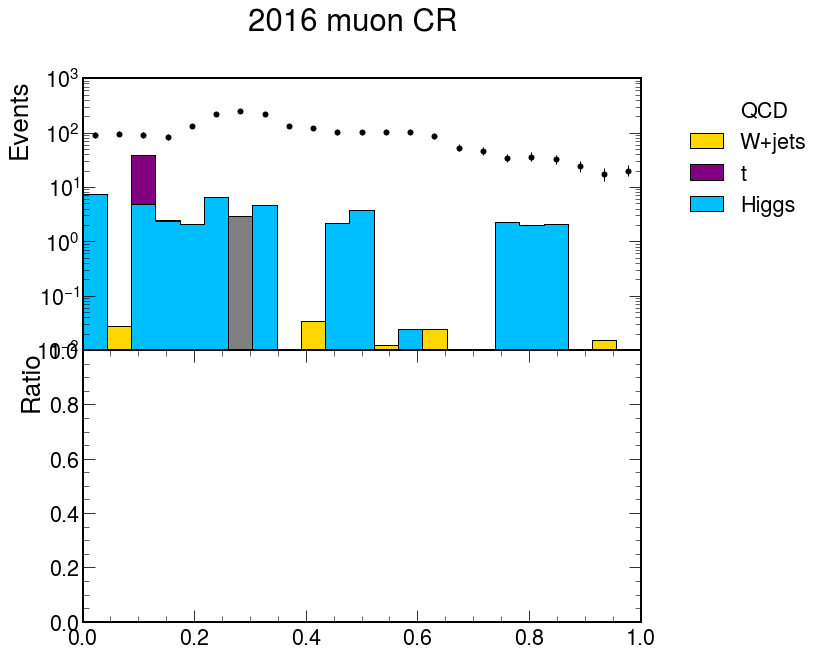

In [9]:
h = templates.sum('ddb1','pt1').integrate('region', 'muoncontrol')
plot_datamc(h,year+'/inclusive/muCR_msd1',year+" muon CR")

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


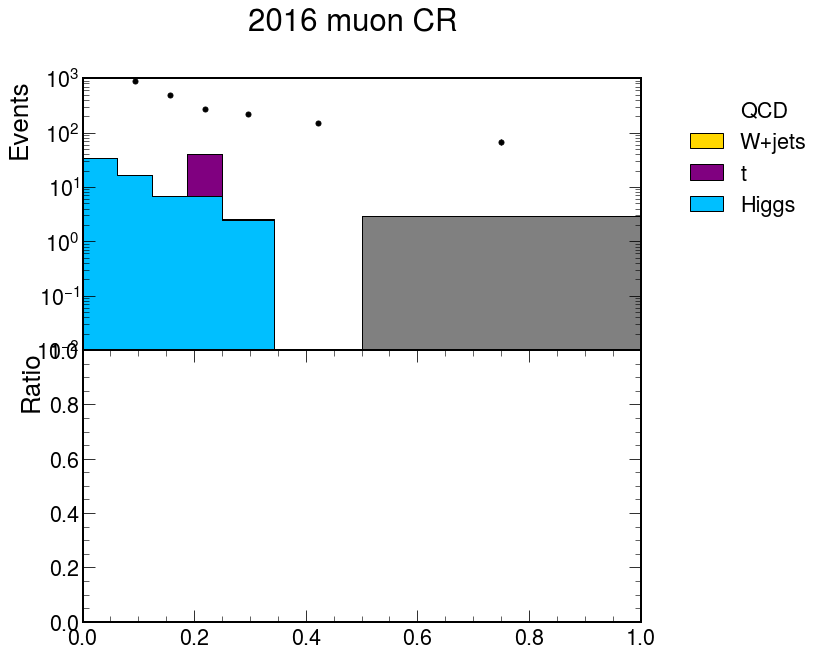

In [10]:
h = mujetkin.integrate('region', 'muoncontrol').sum('msd1','eta1','ddb1')
plot_datamc(h,year+'/inclusive/muCR_pt1',year+" muon CR")

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


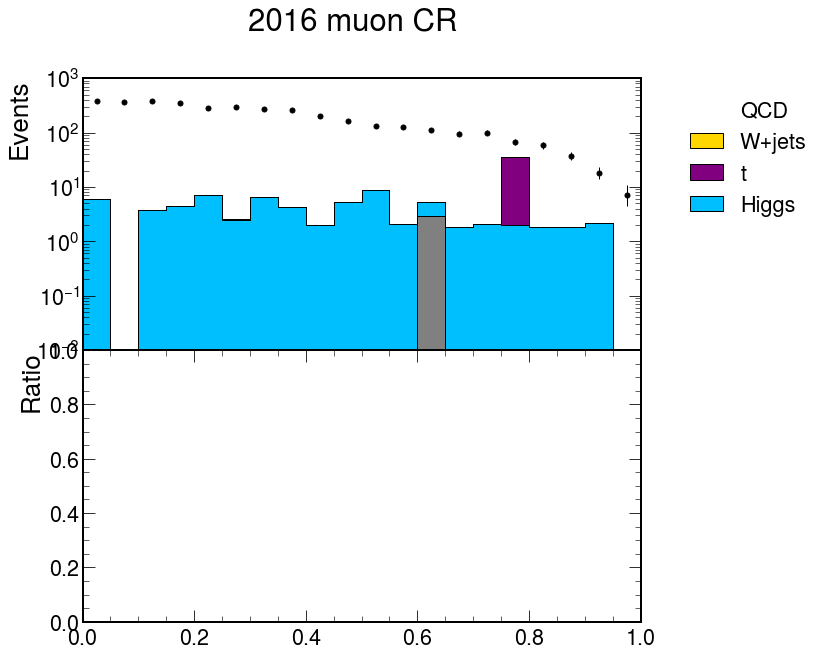

In [11]:
h = mujetkin.integrate('region', 'muoncontrol').sum('msd1','pt1','ddb1')
plot_datamc(h,year+'/inclusive/muCR_eta1',year+" muon CR")

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


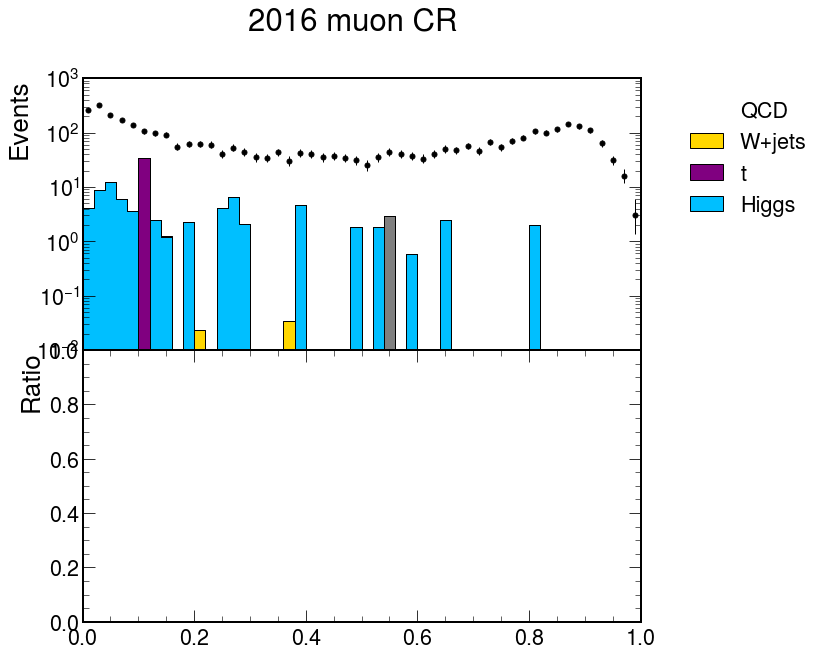

In [12]:
h = mujetkin.integrate('region', 'muoncontrol').sum('msd1','pt1','eta1')
plot_datamc(h,year+'/inclusive/muCR_ddb1',year+" muon CR")

/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


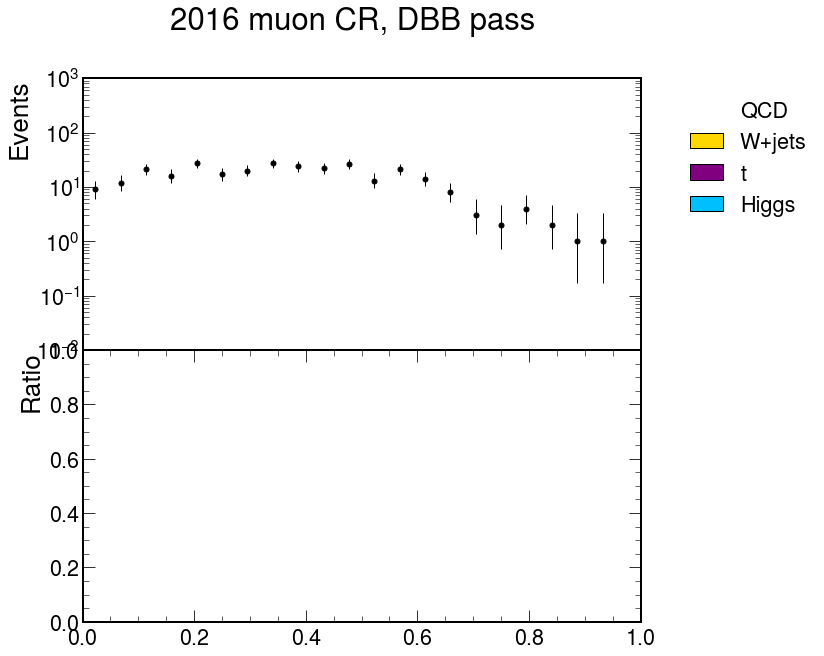

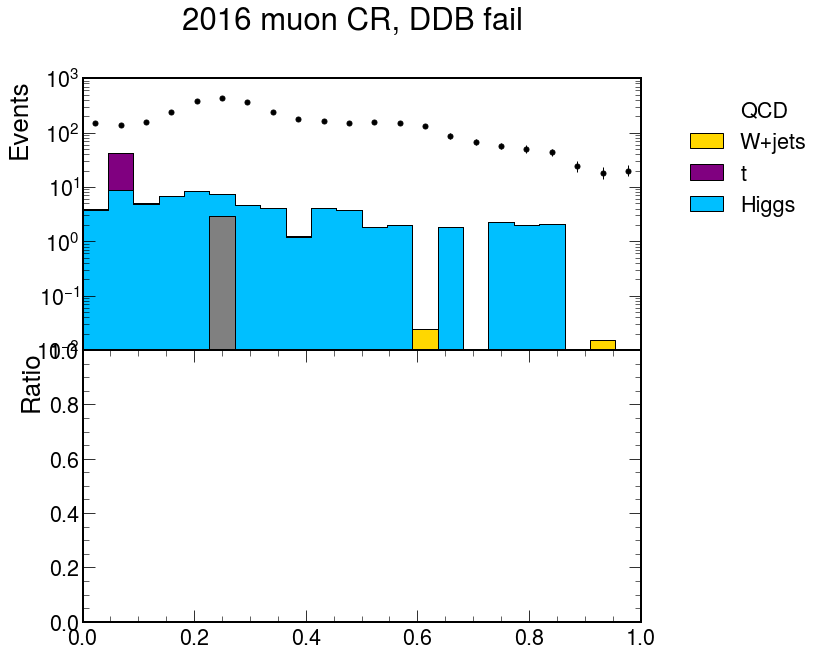

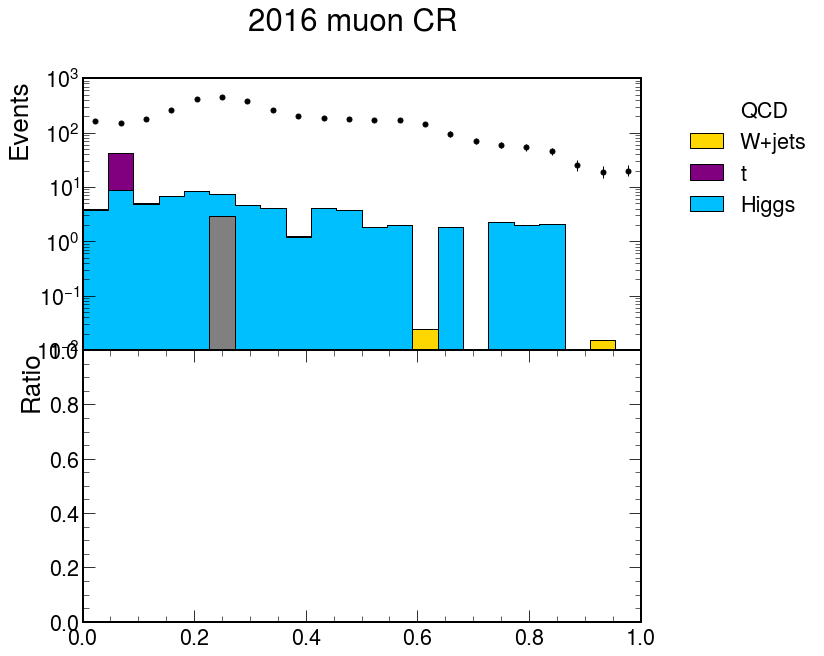

In [13]:
h = muonkin.integrate('region', 'muoncontrol').sum('ptmu','etamu').integrate('ddb1',int_range=slice(0.89,1))
plot_datamc(h,year+'/inclusive/muCR_msd1_pass',year+" muon CR, DBB pass")
h = muonkin.integrate('region', 'muoncontrol').sum('ptmu','etamu').integrate('ddb1',int_range=slice(0,0.89))
plot_datamc(h,year+'/inclusive/muCR_msd1_fail',year+" muon CR, DDB fail")
h = muonkin.integrate('region', 'muoncontrol').sum('ptmu','etamu','ddb1')
plot_datamc(h,year+'/inclusive/muCR_msd1',year+" muon CR")  

/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


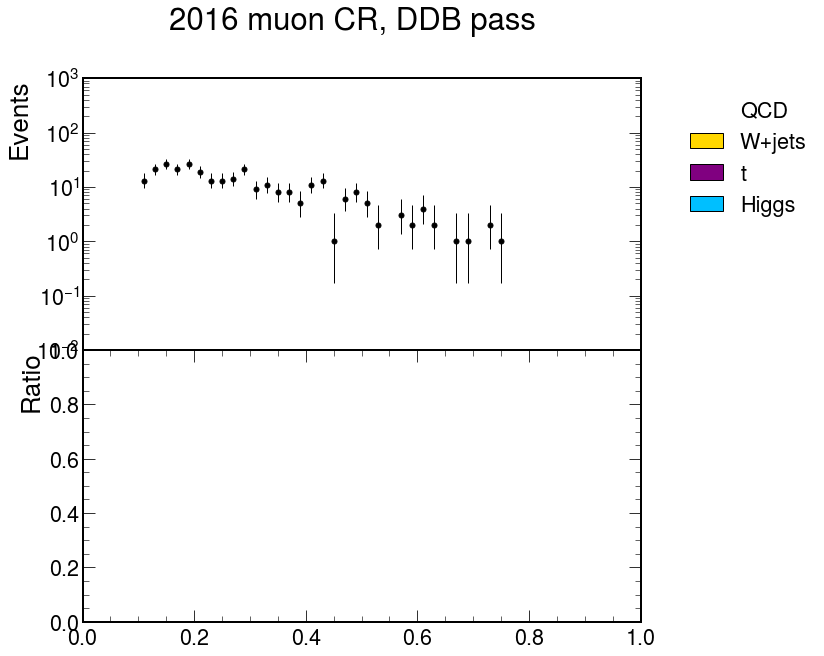

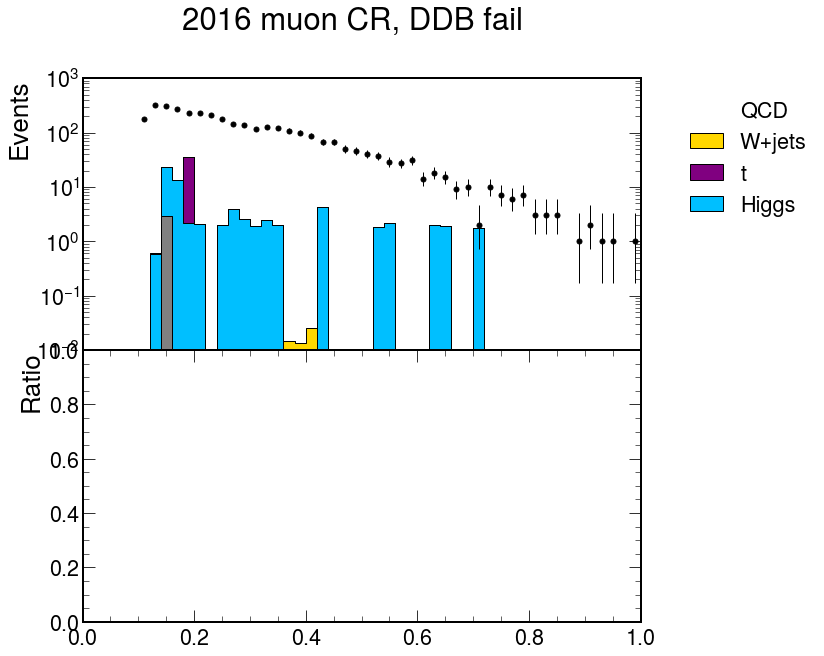

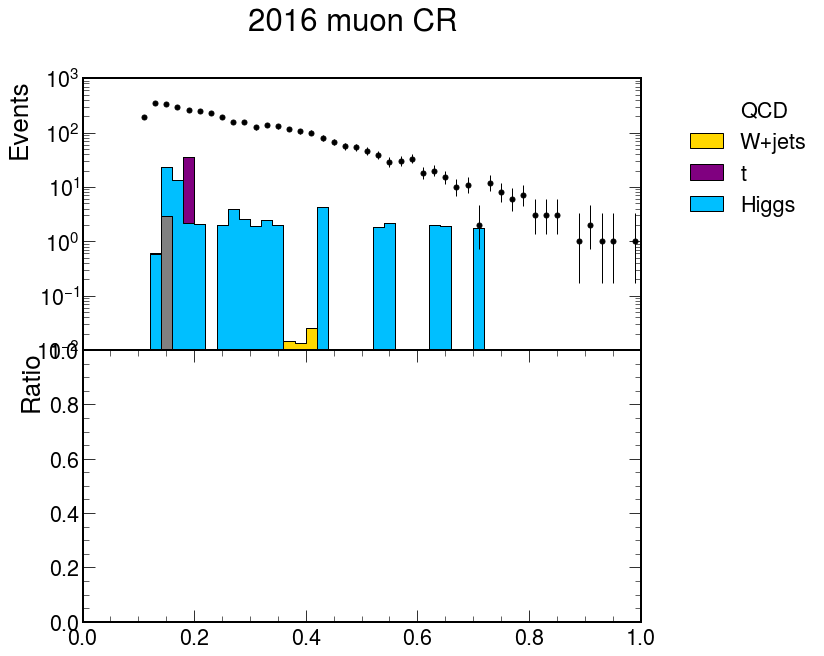

In [14]:
h = muonkin.integrate('region', 'muoncontrol').sum('msd1','etamu').integrate('ddb1',int_range=slice(0.89,1))
plot_datamc(h,year+'/inclusive/muCR_ptmu_pass',year+" muon CR, DDB pass")
h = muonkin.integrate('region', 'muoncontrol').sum('msd1','etamu').integrate('ddb1',int_range=slice(0,0.89))
plot_datamc(h,year+'/inclusive/muCR_ptmu_fail',year+" muon CR, DDB fail")
h = muonkin.integrate('region', 'muoncontrol').sum('msd1','etamu','ddb1')
plot_datamc(h,year+'/inclusive/muCR_ptmu',year+" muon CR")

/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


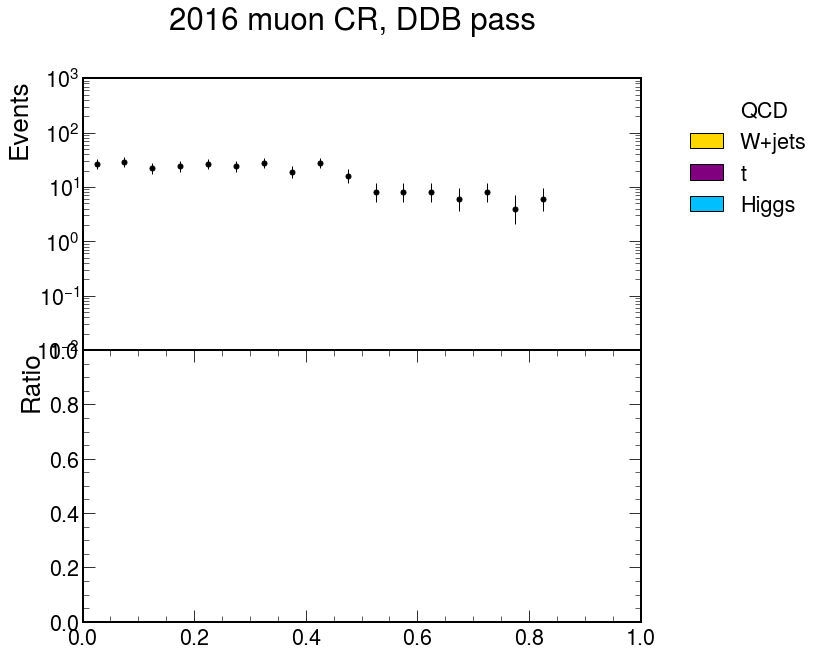

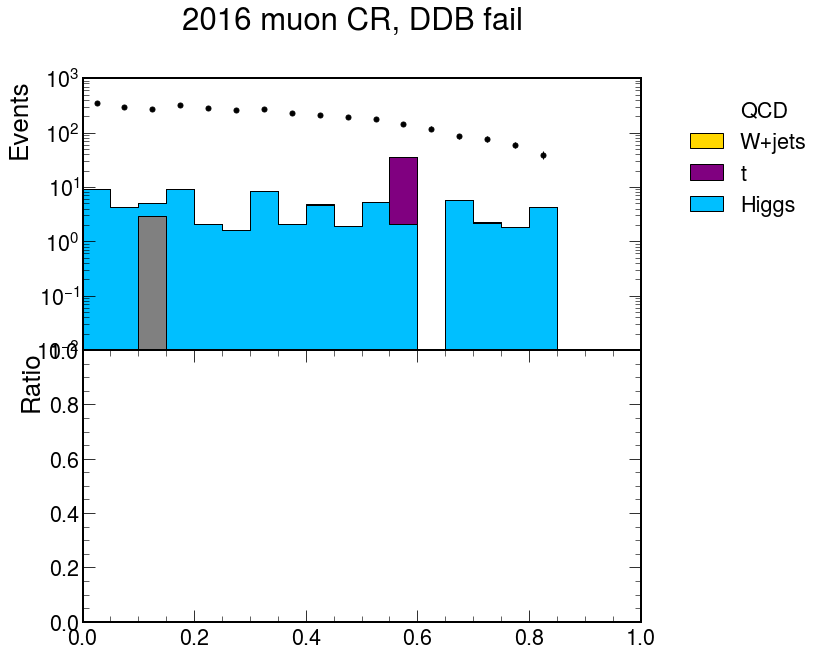

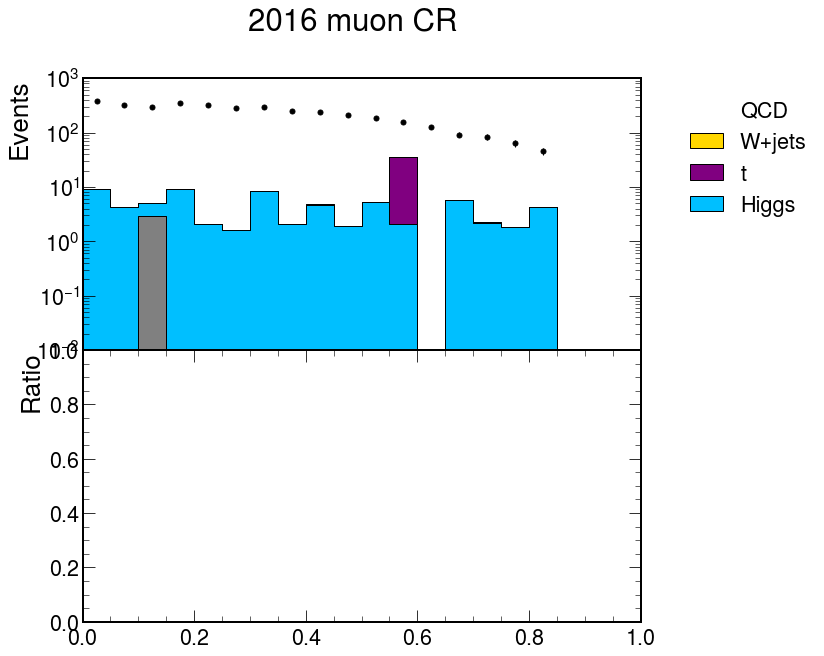

In [15]:
h = muonkin.integrate('region', 'muoncontrol').sum('msd1','ptmu').integrate('ddb1',int_range=slice(0.89,1))
plot_datamc(h,year+'/inclusive/muCR_etamu_pass',year+" muon CR, DDB pass")
h = muonkin.integrate('region', 'muoncontrol').sum('msd1','ptmu').integrate('ddb1',int_range=slice(0,0.89))
plot_datamc(h,year+'/inclusive/muCR_etamu_fail',year+" muon CR, DDB fail")
h = muonkin.integrate('region', 'muoncontrol').sum('msd1','ptmu','ddb1')
plot_datamc(h,year+'/inclusive/muCR_etamu',year+" muon CR")